In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

from optical_bloch.julia_utils import (
    OdeParameters,
    init_julia,
    OBEProblem,
    OBEProblemConfig,
    setup_solve_problem,
    init_julia_ensemble,
    OBEEnsembleProblem,
    OBEEnsembleProblemConfig,
    solve_problem_ensemble,
    setup_ensemble_problem,
    get_diagonal_indices_flattened,
    get_results,
    OBEResult,
)

plt.rcParams.update({"font.size": 14})


c:\Users\ogras\anaconda3\envs\optical-bloch-python\Lib\site-packages\juliacall\__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
energies = smp.symbols("E0:3", real=True)

omegas = smp.symbols("ω0:2", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:2", real=True)
Gammas = smp.symbols("Γ0:2", real=True)
ham = Hamiltonian(3)
ham.add_energies(energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(1, 2, Omegas[1], omegas[1])

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(1, 2, deltas[1])

display(ham.transformed)

ham.remove_common_energy()

transformed = ham.transformed

transformed
dis = Dissipator(ham.levels)

for idi, idf, Gamma in zip([2, 2], [0, 1], Gammas):
    dis.add_decay(idi, idf, Gamma)

bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(bloch.equations.rhs, bloch.density_matrix, [])
)


Matrix([
[                               E0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2],
[                                0,                                E1, -Ω1*exp(1.0*I*t*ω1)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2,                    E2]])

Matrix([
[         E0 + ω0,                0, -Ω0/2],
[               0,          E1 + ω1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2]])

Matrix([
[         E2 - δ0,                0, -Ω0/2],
[               0,          E2 - δ1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2]])

In [3]:
transformed

Matrix([
[             -δ0,                0, -Ω0/2],
[               0,              -δ1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0]])

In [4]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		Ω0 = p[3]
		Ω1 = p[4]
		δ0 = p[5]
		δ1 = p[6]
		du[1,1] = Γ0*u[3,3] + 1.0im*(Ω0*conj(u[1,3]) - u[1,3]*conj(Ω0))/2
		du[1,2] = 1.0im*(Ω0*conj(u[2,3])/2 + δ0*u[1,2] - δ1*u[1,2] - u[1,3]*conj(Ω1)/2)
		du[1,3] = -(Γ0 + Γ1)*u[1,3]/2 - 1.0im*(Ω0*u[1,1] - Ω0*u[3,3] + Ω1*u[1,2] - 2*δ0*u[1,3])/2
		du[2,2] = Γ1*u[3,3] + 1.0im*(Ω1*conj(u[2,3]) - u[2,3]*conj(Ω1))/2
		du[2,3] = -(Γ0 + Γ1)*u[2,3]/2 - 1.0im*(Ω0*conj(u[1,2]) + Ω1*u[2,2] - Ω1*u[3,3] - 2*δ1*u[2,3])/2
		du[3,3] = -(Γ0 + Γ1)*u[3,3] - 1.0im*(Ω0*conj(u[1,3]) + Ω1*conj(u[2,3]) - u[1,3]*conj(Ω0) - u[2,3]*conj(Ω1))/2
	end
	nothing
end


In [5]:
from juliacall import Main as jl

init_julia(code)


In [6]:
from juliacall import Main as jl

In [7]:
from numbers import Number
import numpy as np
import numpy.typing as npt
import re


class OdeParameters:
    def __init__(
        self,
        free_parameters: Sequence[smp.Symbol],
        compound_parameters: Sequence[tuple[smp.Symbol, smp.Expr]],
        fixed_parameters: Sequence[tuple[smp.Symbol, Number]],
    ) -> None:
        self._free_parameters = dict([(str(par), par) for par in free_parameters])
        self._compound_parameters = dict(
            [(str(par), par) for par, _ in compound_parameters]
        )
        self._fixed_parameters = dict([(str(par), par) for par, _ in fixed_parameters])

        for key, val in fixed_parameters + compound_parameters:
            setattr(self, str(key), val)
        for key in free_parameters:
            setattr(self, str(key), None)

    def __repr__(self) -> str:
        rep = "OdeParameters("
        for par in self._free_parameters:
            rep += f"{par}={getattr(self, par)}, "
        return rep.strip(", ") + ")"

    def __setattr__(self, name: str, value) -> None:
        if name in [
            "_free_parameters",
            "_compound_parameters",
            "_fixed_parameters",
        ]:
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._free_parameters.keys():
            assert not isinstance(
                value, smp.Expr
            ), "Cannot change parameter from numeric to str"
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._compound_parameters.keys():
            assert isinstance(
                value, smp.Expr
            ), "Cannot change parameter from str to numeric"
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._fixed_parameters.keys():
            assert not isinstance(value, smp.Expr), "Cannot change numeric to str"
            super(OdeParameters, self).__setattr__(name, value)
        else:
            raise AssertionError(
                "Cannot instantiate new parameter on initialized OdeParameters object"
            )

    @property
    def parameter_values(self) -> dict[smp.Symbol, Number | smp.Expr | smp.Symbol]:
        parameter_values: dict[smp.Symbol, Number | smp.Expr | smp.Symbol] = {}
        for par_str, par in self._compound_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        for par_str, par in self._fixed_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        for par_str, par in self._free_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        return parameter_values

    @property
    def fixed_parameters(self) -> dict[smp.Symbol, Number]:
        return dict(
            [(par, getattr(self, str(par))) for par in self._fixed_parameters.values()]
        )

    @property
    def free_parameters(self) -> dict[smp.Symbol, Number]:
        return dict(
            [(par, getattr(self, str(par))) for par in self._free_parameters.values()]
        )

    @property
    def compound_parameters(self) -> dict[smp.Symbol, smp.Expr]:
        return dict(
            [
                (par, getattr(self, str(par)))
                for par in self._compound_parameters.values()
            ]
        )

    @property
    def p(self) -> tuple[Number]:
        return tuple([getattr(self, par) for par in self._free_parameters.keys()])

    def _time_evolution_compound_parameter(
        self, parameter: str, t: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        expression = self._compound_parameters[parameter]

        expression = expression.subs(self.parameter_values)

        # vectorize over all function calls dotting (.) function calls, e.g. sin.(t)
        # instead of sin(t)
        pattern = r"([a-zA-Z])\("
        str_expression = re.sub(pattern, r"\1.(", str(expression))

        # vectorize full expression by putting a dot (.) before all mathematical
        # operators
        pattern = r"([+\-*/^=<>])"
        str_expression = re.sub(pattern, r".\1", str_expression)

        from juliacall import Main as jl

        jl.t = t
        return np.array(jl.seval(str_expression))


In [8]:
odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)
odepars


OdeParameters(Γ0=None, Γ1=None, Ω0=None, Ω1=None, δ0=None, δ1=None)

In [9]:
odepars.Γ0 = 1 / 2
odepars.Γ1 = 1 / 2
odepars.Ω0 = 1.0
odepars.Ω1 = 1.0
odepars.δ0 = 0.0
odepars.δ1 = 0.0


In [10]:
ρ = np.zeros(transformed.shape, dtype=complex)
for idx in range(2):
    ρ[idx, idx] = 1 / 2

problem = OBEProblem(odepars, ρ, (0, 150))
config = OBEProblemConfig(save_everystep=True)


In [11]:
sol = setup_solve_problem(problem, config)

In [12]:
jl.seval("""
using LinearAlgebra
using MKL
using StaticArrays

function func_hamiltonian_commutator!(du, hamiltonians, prefactors, ρ)
    fill!(du, 0.0im)
    for idx in 1:length(hamiltonians)
        mul!(du, hamiltonians[idx], ρ, prefactors[idx], 1.0)
        mul!(du, ρ, hamiltonians[idx], -prefactors[idx], 1.0)
    end
end


function decays!(du, decays, prefactors, ρ, buffers)
    tmp, G, GT, G2 = buffers
    for idx in 1:length(decays)
        G .= sqrt(prefactors[idx]).*decays[idx]
        GT .= transpose(G)
        mul!(G2, GT, G)
        mul!(du, G2, ρ, -1/2, 1.0)
        mul!(du, ρ, G2, -1/2, 1.0)
        mul!(tmp, ρ, GT)
        mul!(du, G, tmp, 1.0, 1.0)
    end
end
""")


decays! (generic function with 1 method)

In [13]:
from dataclasses import dataclass


@dataclass
class Coupling:
    Ω: smp.Symbol
    δ: smp.Symbol
    H: np.array
    δ_matrix: np.array


def get_couplings(hamiltonian: Hamiltonian) -> list[Coupling]:
    couplings = []
    for cpl in hamiltonian.detunings:
        ω, Eg, Ee, δ, initial, final = cpl
        Ω = hamiltonian.rabis[(initial, final)]
        free_symbols = list(hamiltonian.transformed.free_symbols)
        det = np.array(
            hamiltonian.transformed.subs(
                [(val, 0) for val in [s for s in free_symbols if s != δ]]
            ).subs(δ, 1),
            dtype=np.complex128,
        )
        H = np.array(
            hamiltonian.transformed.subs(
                [(val, 0) for val in [s for s in free_symbols if s != Ω]]
            ).subs(Ω, 1),
            dtype=np.complex128,
        )
        couplings.append(Coupling(Ω, δ, H, det))
    return couplings


In [14]:
@dataclass
class Decay:
    Γ: smp.Symbol
    Γ_matrix: np.array


def get_decays(dissipator: Dissipator) -> list[Decay]:
    decays = []
    for initial, final, symbol in dissipator.decays:
        Γ_matrix = np.zeros(dis.dissipator.shape, dtype=np.complex128)
        Γ_matrix[final, initial] = 1.0
        decays.append(Decay(symbol, Γ_matrix))
    return decays


In [151]:
from numbers import Number

from optical_bloch.generate_code import (
    get_parameters_functions,
    defined_julia_functions,
)


def generate_new_julia_code(
    equation_rhs: smp.matrices.MutableDenseMatrix,
    couplings: list[Coupling],
    decays: list[Decay],
    replacements: list[tuple[smp.Symbol, Number | smp.Expr]] = [],
    function_name: str = "lindblad!",
    simplify: bool = True,
):
    free_parameters, fixed_parameters, compound_parameters, functions = (
        get_parameters_functions(equation_rhs, replacements)
    )

    julia_functions = defined_julia_functions()
    for func in functions:
        assert str(func) in julia_functions, f'Function "{func}" not defined in Julia'

    function = f"""function {function_name}(du, u, p, t)
    \t@inbounds begin
    """
    for idp, parameter in enumerate(free_parameters):
        function += f"\t\t{parameter} = p[{idp+1}]\n"
    if len(replacements) > 0:
        for parameter, value in fixed_parameters:
            function += f"\t\t{parameter} = {value}\n"
        for parameter, value in compound_parameters:
            function += f"\t\t{parameter} = {value}\n"
    function += f"\t\thamiltonians = p[{idp+2}]\n"
    function += f"\t\tprefactors_hamiltonians = p[{idp+3}]\n"

    function += f"\t\tdecays = p[{idp+4}]\n"
    function += f"\t\tprefactors_decays = p[{idp+5}]\n"
    function += f"\t\tbuffers = p[{idp+6}]\n"

    for idx, coupling in enumerate(couplings):
        function += f"\t\tprefactors_hamiltonians[{idx*3+1}] = {coupling.Ω}\n"
        function += f"\t\tprefactors_hamiltonians[{idx*3+2}] = conj({coupling.Ω})\n"
        function += f"\t\tprefactors_hamiltonians[{idx*3+3}] = {coupling.δ}\n"

    for idx, decay in enumerate(decays):
        function += f"\t\tprefactors_decays[{idx+1}] = {decay.Γ}\n"

    function += "\t\tfunc_hamiltonian_commutator!(du, hamiltonians, prefactors_hamiltonians, u)\n"
    function += "\t\tdu .*= -1im\n"
    function += "\t\tdecays!(du, decays, prefactors_decays, u, buffers)\n"
    function += "\tend\n"
    function += "\tnothing\n"
    function += "end"

    return (
        function,
        tuple(free_parameters),
        tuple(compound_parameters),
        tuple(fixed_parameters),
    )


In [152]:
couplings = get_couplings(ham)
decays = get_decays(dis)
function_new, free_params, compound_params, fixed_params = generate_new_julia_code(
    bloch.equations.rhs, couplings, decays, function_name="lindblad_new!"
)
print(function_new)
jl.seval(function_new)


function lindblad_new!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		Ω0 = p[3]
		Ω1 = p[4]
		δ0 = p[5]
		δ1 = p[6]
		hamiltonians = p[7]
		prefactors_hamiltonians = p[8]
		decays = p[9]
		prefactors_decays = p[10]
		buffers = p[11]
		prefactors_hamiltonians[1] = Ω0
		prefactors_hamiltonians[2] = conj(Ω0)
		prefactors_hamiltonians[3] = δ0
		prefactors_hamiltonians[4] = Ω1
		prefactors_hamiltonians[5] = conj(Ω1)
		prefactors_hamiltonians[6] = δ1
		prefactors_decays[1] = Γ0
		prefactors_decays[2] = Γ1
		func_hamiltonian_commutator!(du, hamiltonians, prefactors_hamiltonians, u)
		du .*= -1im
		decays!(du, decays, prefactors_decays, u, buffers)
	end
	nothing
end


lindblad_new! (generic function with 1 method)

In [153]:
def generate_buffers_julia(size: int, use_static_arrays: bool = True):
    if use_static_arrays:
        jl.seval(f"""
            buff = @MMatrix zeros(Complex{{Float64}},{size},{size})
            G = @MMatrix zeros(Complex{{Float64}},{size},{size})
            GT = @MMatrix zeros(Complex{{Float64}},{size},{size})
            G2 = @MMatrix zeros(Complex{{Float64}},{size},{size})
            buffers = [buff, G, GT, G2]
        """)
    else:
        jl.seval(f"""
            tmp = zeros(Complex{{Float64}},{size},{size})
            G = zeros(Complex{{Float64}},{size},{size})
            GT = zeros(Complex{{Float64}},{size},{size})
            G2 = zeros(Complex{{Float64}},{size},{size})
            buffers = [tmp, G, GT, G2]
        """)


def generate_couplings_julia(couplings: list[Coupling], use_static_arrays: bool = True):
    size = couplings[0].H.shape[0]
    static_arrays = (
        f"SMatrix{{{size}, {size},Complex{{Float64}}}}" if use_static_arrays else ""
    )
    for idx, coupling in enumerate(couplings):
        setattr(jl, f"coupling{idx+1}", coupling.H)
        jl.seval(f"coupling{idx+1} = {static_arrays}(Matrix(coupling{idx+1}))")
        setattr(jl, f"detuning{idx+1}", coupling.δ_matrix)
        jl.seval(f"detuning{idx+1} = {static_arrays}(Matrix(detuning{idx+1}))")


def generate_decays_julia(decays: list[Decay], use_static_arrays: bool = True):
    static_arrays = (
        f"SMatrix{{{size}, {size},Complex{{Float64}}}}" if use_static_arrays else ""
    )
    for idx, decay in enumerate(decays):
        setattr(jl, f"decay{idx+1}", decay.Γ_matrix)
        jl.seval(f"decay{idx+1} = {static_arrays}(Matrix(decay{idx+1}))")


def generate_julia_matrices(
    couplings: list[Coupling], decays: list[Decay], use_static_arrays: bool = True
):
    size = couplings[0].H.shape[0]
    generate_buffers_julia(size, use_static_arrays)
    generate_couplings_julia(couplings, use_static_arrays)
    generate_decays_julia(decays, use_static_arrays)

    static_arrays = (
        f"SMatrix{{{size}, {size},Complex{{Float64}}}}" if use_static_arrays else ""
    )

    hamiltonian_str = "hamiltonians  = ["
    for idx, _ in enumerate(couplings):
        hamiltonian_str += f"{static_arrays}(triu(Matrix(coupling{idx+1}))),{static_arrays}(tril(Matrix(coupling{idx+1}))),detuning{idx+1},"
    hamiltonian_str = hamiltonian_str.strip(",")
    hamiltonian_str += "]"
    jl.seval(hamiltonian_str)

    decay_str = "decays = ["
    for idx, _ in enumerate(decays):
        decay_str += f"decay{idx+1},"
    decay_str = decay_str.strip(",")
    decay_str += "]"
    jl.seval(decay_str)

    prefactors_hamiltonians = np.zeros(len(couplings) * 3)
    static_arrays = (
        f"MVector{{{prefactors_hamiltonians.size},Complex{{Float64}}}}"
        if use_static_arrays
        else ""
    )
    jl.prefactors_hamiltonians = prefactors_hamiltonians
    jl.seval(
        f"prefactors_hamiltonians =  {static_arrays}(Vector(prefactors_hamiltonians))"
    )

    prefactors_decays = np.zeros(len(decays))
    static_arrays = (
        f"MVector{{{prefactors_decays.size},Complex{{Float64}}}}"
        if use_static_arrays
        else ""
    )
    jl.prefactors_decays = prefactors_decays
    jl.seval(f"prefactors_decays = {static_arrays}(Vector(prefactors_decays))")


In [154]:
print(function_new)

function lindblad_new!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		Ω0 = p[3]
		Ω1 = p[4]
		δ0 = p[5]
		δ1 = p[6]
		hamiltonians = p[7]
		prefactors_hamiltonians = p[8]
		decays = p[9]
		prefactors_decays = p[10]
		buffers = p[11]
		prefactors_hamiltonians[1] = Ω0
		prefactors_hamiltonians[2] = conj(Ω0)
		prefactors_hamiltonians[3] = δ0
		prefactors_hamiltonians[4] = Ω1
		prefactors_hamiltonians[5] = conj(Ω1)
		prefactors_hamiltonians[6] = δ1
		prefactors_decays[1] = Γ0
		prefactors_decays[2] = Γ1
		func_hamiltonian_commutator!(du, hamiltonians, prefactors_hamiltonians, u)
		du .*= -1im
		decays!(du, decays, prefactors_decays, u, buffers)
	end
	nothing
end


In [166]:
generate_julia_matrices(couplings, decays, use_static_arrays=True)

In [198]:
jl.seval("""
    using BenchmarkTools
    pother = (p..., hamiltonians, prefactors_hamiltonians, decays, prefactors_decays, buffers)
    ρother = ρ
    du = MMatrix{3,3,Complex{Float64}}(ρother)
    du .= 0
""")


3×3 MMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im

In [200]:
jl.seval(
    "@benchmark func_hamiltonian_commutator!(du, hamiltonians, prefactors_hamiltonians, ρother)"
)


BenchmarkTools.Trial: 10000 samples with 148 evaluations.
 Range (min … max):  688.514 ns …  10.188 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     885.135 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   956.473 ns ± 308.686 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █ ▃  ▅▄▁▃▃                                                    
  ████▆▄█████▆▆▆▆▆▇▆▇▆▅▄▅▇▅▅█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂ ▄
  689 ns           Histogram: frequency by time         1.82 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [201]:
jl.seval("@benchmark decays!(du, decays, prefactors_decays, ρother, buffers)")

BenchmarkTools.Trial: 10000 samples with 149 evaluations.
 Range (min … max):  683.893 ns …  13.544 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     871.141 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   914.465 ns ± 346.210 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █ ▄  ▄▁▁▃▃▁                                                   
  ▆███▇████████▅▆▇▆█▆▆█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂ ▃
  684 ns           Histogram: frequency by time         1.86 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [202]:
jl.seval("@benchmark lindblad_new!(du, ρ, pother, 1e-6)")

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.360 μs …  36.340 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.710 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.862 μs ± 856.397 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▆▇▄▃▃▇█▇▅▅▅▆▅▄▄▃▃▃▂▂    ▁▁▁▁    ▁                          ▂
  ███████████████████████▇▇███████▇█▇█▇▇▇▇▇▆▆▇▅▆▆▃▆▅▅▆▄▆▅▆▅▆▆ █
  1.36 μs      Histogram: log(frequency) by time      3.95 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

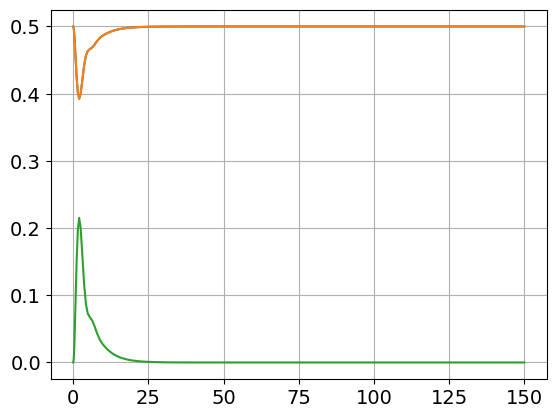

In [203]:
jl.seval("""
prob = ODEProblem(lindblad!, ρ, (0,150), p)
sol = solve(prob, Tsit5())
""")
sol = get_results("sol")
res = np.einsum("ijj->ij", sol.y).real

fig, ax = plt.subplots()
ax.plot(sol.t, res)
ax.grid()


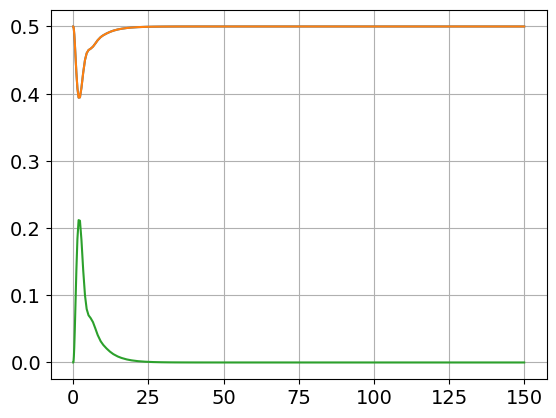

In [204]:
jl.seval("""
prob_new = ODEProblem(lindblad_new!, ρ, (0,150), pother)
sol_new = solve(prob_new, Tsit5())
""")
sol_new = get_results("sol_new")

res_new = np.einsum("ijj->ij", sol_new.y).real

fig, ax = plt.subplots()
ax.plot(sol_new.t, res_new)
ax.grid()


In [205]:
jl.seval("@benchmark solve(prob_new, Tsit5())")

BenchmarkTools.Trial: 2707 samples with 1 evaluation.
 Range (min … max):  1.361 ms …   8.875 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.786 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.823 ms ± 360.405 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▄▃▁             ▃▅█▇▅▂                                     
  ▅████▇▆▃▄▄▃▃▃▃▃▃▄▆██████▇▅▄▃▄▅▄▄▅▄▆▅▃▃▃▃▄▅▅▆▅▄▃▂▃▃▃▃▂▂▁▁▁▁▁ ▃
  1.36 ms         Histogram: frequency by time        2.53 ms <

 Memory estimate: 216.91 KiB, allocs estimate: 1890.

In [206]:
jl.seval("@benchmark solve(prob, Tsit5())")

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  108.800 μs … 193.644 ms  ┊ GC (min … max):  0.00% … 99.81%
 Time  (median):     178.350 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   213.859 μs ±   1.943 ms  ┊ GC (mean ± σ):  12.13% ±  4.43%

  ▁▇█▃   ▁ ▁    ▁       ▁                                        
  █████▅▆███▇▇▇██████▇████▆▄▄▄▃▃▂▃▂▂▂▂▃▂▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  109 μs           Histogram: frequency by time          403 μs <

 Memory estimate: 157.91 KiB, allocs estimate: 816.

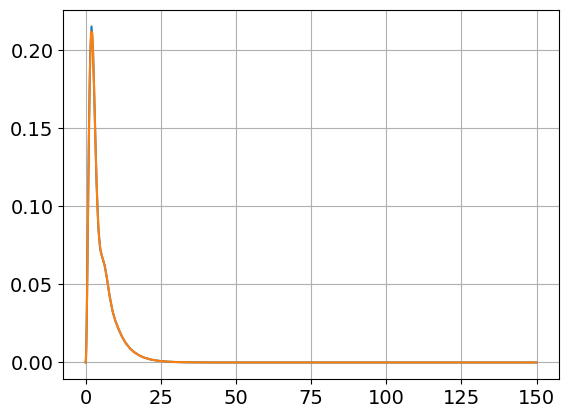

In [207]:
fig, ax = plt.subplots()
ax.plot(sol.t, res.T[2])
ax.plot(sol_new.t, res_new.T[2])
ax.grid()


# Larger system

In [208]:
# 4 ground states, 3 excited states (i.e. F=0, F=1 to F=1 excited)

ω = smp.Symbol("ω", real=True)
Ωz = smp.Symbol("Ωz", complex=True)
Ωx = smp.Symbol("Ωx", complex=True)
δ = smp.Symbol("δ", real=True)

ham = Hamiltonian(7)

# Z polarization
ham.add_manifold_coupling(
    [0, 1, 3],
    [5, 4, 6],
    Ωz,
    ω,
)

# X polarization
ham.add_manifold_coupling([0, 0, 1, 2, 2, 3], [4, 6, 5, 4, 6, 5], Ωx, ω)

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 5, δ)
ham.remove_common_energy()

display(ham.transformed)


Matrix([
[                              E0,                                0,                                0,                                0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                               E1,                                0,                                0, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2,                    0],
[                               0,                                0,                               E2,                                0, -Ωx*exp(1.0*I*t*ω)/2,                    0, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                                0,                                0,                               E3,                    0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2],
[-exp(-1.0*I*t*ω)*conjugate(Ωx)/2, -exp(-1.0*I*t*ω)*conjugate(Ωz)/2, -exp(-1.0*I*t*ω)*conjugate(Ωx)/2,                                0,                   E4,                 

Matrix([
[          E0 + ω,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,           E1 + ω,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,           E2 + ω,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,           E3 + ω,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,    E4,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,    E5,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,    E6]])

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [209]:
ham.detunings

[[ω, E0, E5, δ, 0, 5]]

In [210]:
ham.eqn_transform_graph()
display(ham.transformed)

ham._replace_with_detunings()

ham.remove_common_energy()

display(ham.transformed)


Matrix([
[          E0 + ω,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,           E1 + ω,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,           E2 + ω,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,           E3 + ω,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,    E4,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,    E5,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,    E6]])

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [211]:
Γ = smp.Symbol("Γ", real=True)
dis = Dissipator(ham.levels)

for idi, idf in zip([4, 4, 4, 5, 5, 5, 6, 6, 6], [0, 1, 2, 0, 1, 3, 0, 2, 3]):
    dis.add_decay(idi, idf, Γ)

display(dis.dissipator)


Matrix([
[Γ*(ρ44(t) + ρ55(t) + ρ66(t)),                        0,                        0,                        0,          -3*Γ*ρ04(t)/2,          -3*Γ*ρ05(t)/2, -3*Γ*ρ06(t)/2],
[                           0,      Γ*(ρ44(t) + ρ55(t)),                        0,                        0,          -3*Γ*ρ14(t)/2,          -3*Γ*ρ15(t)/2, -3*Γ*ρ16(t)/2],
[                           0,                        0,      Γ*(ρ44(t) + ρ66(t)),                        0,          -3*Γ*ρ24(t)/2,          -3*Γ*ρ25(t)/2, -3*Γ*ρ26(t)/2],
[                           0,                        0,                        0,      Γ*(ρ55(t) + ρ66(t)),          -3*Γ*ρ34(t)/2,          -3*Γ*ρ35(t)/2, -3*Γ*ρ36(t)/2],
[    -3*Γ*conjugate(ρ04(t))/2, -3*Γ*conjugate(ρ14(t))/2, -3*Γ*conjugate(ρ24(t))/2, -3*Γ*conjugate(ρ34(t))/2,            -3*Γ*ρ44(t),            -3*Γ*ρ45(t),   -3*Γ*ρ46(t)],
[    -3*Γ*conjugate(ρ05(t))/2, -3*Γ*conjugate(ρ15(t))/2, -3*Γ*conjugate(ρ25(t))/2, -3*Γ*conjugate(ρ35(t))/2, -3*Γ*conjugate(ρ4

In [212]:
E0, E1, E2, E3, E4, E5, E6 = ham.energies
replacements = [(E2, E1), (E3, E1), (E4, E2), (E5, E2), (E6, E2)]
transformed = ham.transformed.copy()
transformed = transformed.subs(replacements)


In [213]:
bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [214]:
replacements = [
    (Ωx, "Ω0*resonant_switching(t, ωpol, 0.0)"),
    (Ωz, "Ω0*resonant_switching(t, ωpol, 3.1415)"),
    (E0, 0),
    (E1, 0.1),
]

code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements
    )
)


In [215]:
odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)
odepars

odepars.Ω0 = 1.0
odepars.Γ = 1.0
odepars.δ = 0.0
odepars.ωpol = 0.5


In [216]:
init_julia(code)

In [217]:
ρ = np.zeros(transformed.shape, dtype=complex)
for idx in range(4):
    ρ[idx, idx] = 1 / 4

problem = OBEProblem(odepars, ρ, (0, 150))
config = OBEProblemConfig(save_everystep=True)


In [218]:
sol = setup_solve_problem(problem, config)

15.55


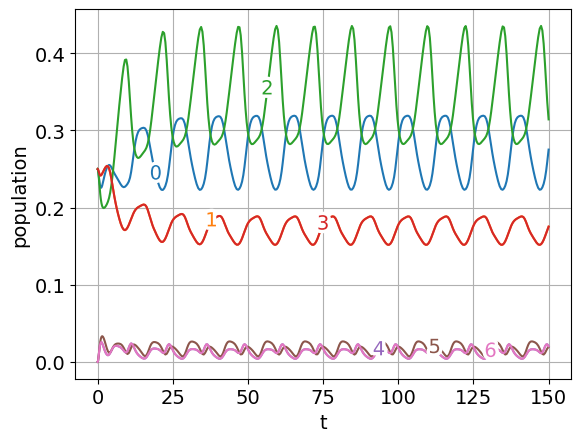

In [219]:
from labellines import labelLines

t = sol.t
y = np.einsum("ijj -> ij", sol.y).real

fig, ax = plt.subplots()
ax.plot(t, y, label=np.arange(ham.levels))

ax.set_xlabel("t")
ax.set_ylabel("population")

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.grid()

print(f"{np.trapezoid(y[:, -3:].sum(axis=1)):.2f}")


In [223]:
jl.seval("du = similar(ρ)")
jl.seval("@benchmark lindblad!(du, ρ, p, 1e-6)")


BenchmarkTools.Trial: 10000 samples with 796 evaluations.
 Range (min … max):  155.653 ns …  2.292 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     208.794 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   218.237 ns ± 68.412 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▇▄█    ▂ ▃▂  ▂▁ ▃                                            
  ▄███▄▂▂▆████▇▄█████▅▄▄▄▃▃▄▄▃▃▃▃▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  156 ns          Histogram: frequency by time          418 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [226]:
transformed

Matrix([
[              -δ,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,     -E0 + E1 - δ,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,     -E0 + E1 - δ,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,     0,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,     0,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,     0]])

In [ ]:
jl.seval("@benchmark solve(prob, Tsit5())")

In [221]:
ham.transformed

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [240]:
to_zero = [s for s in list(ham.transformed.free_symbols) if s not in ham.energies]
H0 = transformed.copy()
for s in to_zero:
    H0 = H0.subs(s, 0)
H0


Matrix([
[0,        0,        0,        0, 0, 0, 0],
[0, -E0 + E1,        0,        0, 0, 0, 0],
[0,        0, -E0 + E1,        0, 0, 0, 0],
[0,        0,        0, -E0 + E1, 0, 0, 0],
[0,        0,        0,        0, 0, 0, 0],
[0,        0,        0,        0, 0, 0, 0],
[0,        0,        0,        0, 0, 0, 0]])